Huấn Luyện một Bộ Phân Loại
===========================

Đây rồi. Bạn đã thấy cách định nghĩa các mạng nơ-ron, tính toán mất mát và cập nhật trọng số của mạng.

Bây giờ bạn có thể đang nghĩ,

Còn dữ liệu thì sao?
--------------------

Nhìn chung, khi bạn phải xử lý dữ liệu hình ảnh, văn bản, âm thanh hoặc video, bạn có thể sử dụng các gói Python tiêu chuẩn tải dữ liệu vào mảng numpy. Sau đó, bạn có thể chuyển đổi mảng này thành `torch.*Tensor`.

-   Đối với hình ảnh, các gói như Pillow, OpenCV rất hữu ích
-   Đối với âm thanh, các gói như scipy và librosa
-   Đối với văn bản, tải Python hoặc Cython thuần túy, hoặc NLTK và SpaCy rất hữu ích

Đặc biệt đối với thị giác máy tính, chúng tôi đã tạo một gói có tên là `torchvision`, có các trình tải dữ liệu cho các bộ dữ liệu phổ biến như ImageNet, CIFAR10, MNIST, v.v. và các bộ chuyển đổi dữ liệu cho hình ảnh, cụ thể là `torchvision.datasets` và `torch.utils.data.DataLoader`.

Điều này cung cấp sự tiện lợi rất lớn và tránh viết mã boilerplate.

Trong hướng dẫn này, chúng tôi sẽ sử dụng bộ dữ liệu CIFAR10. Nó có các lớp: 'máy bay', 'ô tô', 'chim', 'mèo', 'nai', 'chó', 'ếch', 'ngựa', 'tàu', 'xe tải'. Các hình ảnh trong CIFAR-10 có kích thước 3x32x32, tức là hình ảnh màu 3 kênh có kích thước 32x32 pixel.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Huấn luyện một bộ phân loại hình ảnh
-----------------------------------

Chúng ta sẽ thực hiện các bước sau theo thứ tự:

1.  Tải và chuẩn hóa các bộ dữ liệu huấn luyện và kiểm tra CIFAR10 bằng `torchvision`
2.  Định nghĩa một Mạng Nơ-ron Chập
3.  Định nghĩa một hàm mất mát
4.  Huấn luyện mạng trên dữ liệu huấn luyện
5.  Kiểm tra mạng trên dữ liệu kiểm tra

### 1. Tải và chuẩn hóa CIFAR10

Sử dụng `torchvision`, rất dễ tải CIFAR10.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

Đầu ra của các bộ dữ liệu torchvision là các hình ảnh PILImage trong khoảng [0, 1]. Chúng tôi chuyển đổi chúng thành Tensors có khoảng chuẩn hóa [-1, 1].

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>LƯU Ý:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>Nếu bạn chạy hướng dẫn này trên Windows hoặc MacOS và gặp lỗi BrokenPipeError hoặc RuntimeError liên quan đến đa xử lý, hãy thử đặt num_worker của torch.utils.data.DataLoader() thành 0.</p>

</div>

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s] 


Hãy để chúng tôi hiển thị một số hình ảnh huấn luyện, để vui.

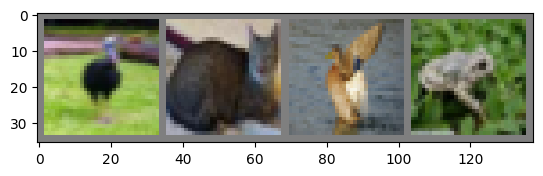

bird  cat   bird  frog 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Định nghĩa một Mạng Nơ-ron Chập
==================================

Sao chép mạng nơ-ron từ phần Mạng Nơ-ron ở trước và sửa đổi nó để chấp nhận hình ảnh 3 kênh (thay vì hình ảnh 1 kênh như được định nghĩa).

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Định nghĩa một hàm mất mát và trình tối ưu hóa
===============================================

Hãy sử dụng mất mát Entropy chéo phân loại và SGD với động lượng.

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Huấn luyện mạng
==================

Đây là lúc mọi thứ bắt đầu trở nên thú vị. Chúng ta chỉ cần vòng lặp trên trình lặp dữ liệu của chúng ta, cung cấp các đầu vào cho mạng và tối ưu hóa.

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.235
[1,  4000] loss: 1.883
[1,  6000] loss: 1.643
[1,  8000] loss: 1.567
[1, 10000] loss: 1.497
[1, 12000] loss: 1.465
[2,  2000] loss: 1.408
[2,  4000] loss: 1.381
[2,  6000] loss: 1.357
[2,  8000] loss: 1.338
[2, 10000] loss: 1.285
[2, 12000] loss: 1.293
Finished Training


Hãy để chúng tôi nhanh chóng lưu mô hình được huấn luyện của chúng ta:

In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Xem [tại đây](https://pytorch.org/docs/stable/notes/serialization.html) để biết thêm chi tiết về lưu các mô hình PyTorch.

5. Kiểm tra mạng trên dữ liệu kiểm tra
======================================

Chúng tôi đã huấn luyện mạng trong 2 lần trên bộ dữ liệu huấn luyện. Nhưng chúng ta cần kiểm tra xem mạng đã học được gì chưa.

Chúng tôi sẽ kiểm tra điều này bằng cách dự đoán nhãn lớp mà mạng nơ-ron đầu ra, và so sánh nó với sự thật cơ bản. Nếu dự đoán đúng, chúng tôi sẽ thêm mẫu vào danh sách các dự đoán đúng.

Được rồi, bước đầu tiên. Hãy để chúng tôi hiển thị một hình ảnh từ bộ kiểm tra để làm quen.

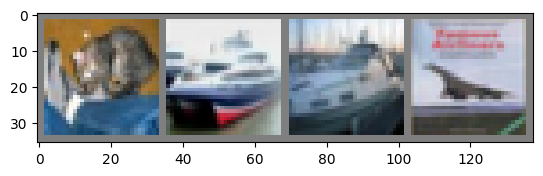

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Tiếp theo, hãy để chúng tôi tải lại mô hình đã lưu của chúng ta (lưu ý: lưu và tải lại mô hình không cần thiết ở đây, chúng tôi chỉ thực hiện để minh họa cách làm):

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Được rồi, bây giờ hãy để chúng tôi xem mạng nơ-ron nghĩ gì về các ví dụ trên:

In [11]:
outputs = net(images)

Các đầu ra là năng lượng cho 10 lớp. Năng lượng càng cao cho một lớp, mạng càng nghĩ rằng hình ảnh thuộc lớp cụ thể đó. Vì vậy, hãy để chúng tôi lấy chỉ mục năng lượng cao nhất:

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   ship 


Kết quả có vẻ khá tốt.

Hãy để chúng tôi xem mạng hoạt động như thế nào trên toàn bộ bộ dữ liệu.

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


Điều đó trông tốt hơn nhiều so với cơ hội, là 10% độ chính xác (chọn ngẫu nhiên một lớp trong 10 lớp). Có vẻ như mạng đã học được cái gì đó.

Hmm, những lớp nào hoạt động tốt, và những lớp nào không hoạt động tốt:

In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.6 %
Accuracy for class: car   is 75.4 %
Accuracy for class: bird  is 25.7 %
Accuracy for class: cat   is 20.8 %
Accuracy for class: deer  is 39.8 %
Accuracy for class: dog   is 47.8 %
Accuracy for class: frog  is 83.5 %
Accuracy for class: horse is 68.2 %
Accuracy for class: ship  is 66.0 %
Accuracy for class: truck is 57.5 %


Được rồi, vậy tiếp theo là gì?

Làm thế nào chúng ta chạy các mạng nơ-ron này trên GPU?

Huấn luyện trên GPU
===================

Giống như cách bạn chuyển một Tensor sang GPU, bạn chuyển mạng nơ-ron sang GPU.

Trước tiên, hãy để chúng tôi định nghĩa thiết bị của chúng ta là thiết bị cuda đầu tiên có thể nhìn thấy nếu chúng ta có CUDA:

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


Phần còn lại của phần này giả định rằng `device` là thiết bị CUDA.

Sau đó, các phương thức này sẽ đi qua tất cả các mô-đun một cách đệ quy và chuyển đổi các tham số và bộ đệm của chúng thành các tensor CUDA:

``` {.python}
net.to(device)
```

Hãy nhớ rằng bạn sẽ phải gửi các đầu vào và mục tiêu ở mỗi bước tới GPU:

``` {.python}
inputs, labels = data[0].to(device), data[1].to(device)
```

Tại sao tôi không nhận thấy tốc độ tăng KHỔNG LỖ so với CPU? Vì mạng của bạn thực sự rất nhỏ.

**Bài tập:** Hãy thử tăng chiều rộng của mạng (đối số 2 của `nn.Conv2d` đầu tiên, và đối số 1 của `nn.Conv2d` thứ hai - chúng phải là cùng một số), xem bạn sẽ nhận được tốc độ tăng loại nào.

**Mục tiêu đạt được**:

-   Hiểu về thư viện Tensor của PyTorch và các mạng nơ-ron ở mức độ cao.
-   Huấn luyện một mạng nơ-ron nhỏ để phân loại hình ảnh

Huấn luyện trên nhiều GPU
=========================

Nếu bạn muốn xem tốc độ tăng KHỔNG LỖ hơn nữa bằng cách sử dụng tất cả GPU của bạn, vui lòng xem `data_parallel_tutorial`.

Tôi nên đi đâu tiếp theo?
===================

-   `Huấn luyện các mạng nơ-ron để chơi trò chơi video </intermediate/reinforcement_q_learning>`
-   [Huấn luyện một mạng ResNet tiên tiến trên imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
-   [Huấn luyện một bộ tạo khuôn mặt sử dụng Mạng Đối kháng sinh tạo](https://github.com/pytorch/examples/tree/master/dcgan)
-   [Huấn luyện một mô hình ngôn ngữ cấp từ sử dụng mạng LSTM lặp lại](https://github.com/pytorch/examples/tree/master/word_language_model)
-   [Thêm ví dụ](https://github.com/pytorch/examples)
-   [Thêm hướng dẫn](https://github.com/pytorch/tutorials)
-   [Thảo luận PyTorch trên Diễn đàn](https://discuss.pytorch.org/)
-   [Trò chuyện với người dùng khác trên Slack](https://pytorch.slack.com/messages/beginner/)

In [16]:
del dataiter